<div align="center">
<p align="center" style="width: 100%;">
    <img src="https://raw.githubusercontent.com/vlm-run/.github/refs/heads/main/profile/assets/vlm-black.svg" alt="VLM Run Logo" width="80" style="margin-bottom: -5px; color: #2e3138; vertical-align: middle; padding-right: 5px;"><br>
</p>
<p align="center"><a href="https://docs.vlm.run"><b>Website</b></a> | <a href="https://docs.vlm.run/"><b>API Docs</b></a> | <a href="https://docs.vlm.run/blog"><b>Blog</b></a> | <a href="https://discord.gg/AMApC2UzVY"><b>Discord</b></a>
</p>
<p align="center">
<a href="https://discord.gg/AMApC2UzVY"><img alt="Discord" src="https://img.shields.io/badge/discord-chat-purple?color=%235765F2&label=discord&logo=discord"></a>
<a href="https://twitter.com/vlmrun"><img alt="Twitter Follow" src="https://img.shields.io/twitter/follow/vlmrun.svg?style=social&logo=twitter"></a>
</p>
</div>

Welcome to **[VLM Run Cookbooks](https://github.com/vlm-run/vlmrun-cookbook)**, a comprehensive collection of examples and notebooks demonstrating the power of structured visual understanding using the [VLM Run Platform](https://app.vlm.run). 

## Case Study: Fashion Product Catalog with Hybrid Search
This notebook demonstrates how to build search for a fashion product catalog system using:
- VLM Run for structured image understanding
- LanceDB for hybrid vector + text search
- CLIP embeddings for visual similarity

### Environment Setup

To get started, install the VLM Run Python SDK and sign-up for an API key on the [VLM Run App](https://app.vlm.run).
- Store the VLM Run API key under the `VLMRUN_API_KEY` environment variable.

### Prerequisites

* Python 3.9+
* VLM Run API key (get one at [app.vlm.run](https://app.vlm.run))
* Basic understanding of vector databases and embeddings

## Setup

First, let's install the required packages:

In [1]:
! pip install lancedb --quiet
! pip install open_clip_torch --quiet
! pip install vlmrun --upgrade --quiet
! pip install vlmrun-hub --upgrade --quiet
! pip install datasets --quiet
! pip install tantivy --quiet  # For full-text search

## Set up CLIP Embeddings

In [2]:
from lancedb.embeddings import EmbeddingFunctionRegistry

registry = EmbeddingFunctionRegistry.get_instance()
clip = registry.get("open-clip").create()

/Users/kaushikbokka/apps/vlm-run/vlmrun-cookbook/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
clip

OpenClipEmbeddings(max_retries=7, name='ViT-B-32', pretrained='laion2b_s34b_b79k', device='cpu', batch_size=64, normalize=True)

## Define Data Schema

In [4]:
from PIL import Image
from lancedb.pydantic import LanceModel, Vector

class FashionImages(LanceModel):
    vector: Vector(clip.ndims()) = clip.VectorField()
    image_uri: str = clip.SourceField()
    description: str
    category: str
    season: str
    gender: str

    @property
    def image(self):
        return Image.open(self.image_uri)

## Configure VLM Run

In [5]:
import os
import getpass

VLMRUN_BASE_URL = os.getenv("VLMRUN_BASE_URL", "https://dev.vlm.run/v1")
VLMRUN_API_KEY = os.getenv("VLMRUN_API_KEY", None)
if VLMRUN_API_KEY is None:
    VLMRUN_API_KEY = getpass.getpass()

 ········


In [6]:
from vlmrun.client import VLMRun

vlm_client = VLMRun(base_url=VLMRUN_BASE_URL, api_key=VLMRUN_API_KEY)

In [7]:
import lancedb

db = lancedb.connect("fashion_imagesdb")

## Load and Process Dataset

In [8]:
from datasets import load_dataset
import logging

def load_fashion_dataset(sample_size="1%"):
    try:
        print(f"Loading {sample_size} of fashion dataset...")
        ds = load_dataset("ashraq/fashion-product-images-small", 
                         split=f"train[:{sample_size}]")
        print(f"Loaded {len(ds)} images successfully")
        return ds
    except Exception as e:
        logging.error(f"Failed to load dataset: {str(e)}")
        raise

ds = load_fashion_dataset("2%")

Loading 2% of fashion dataset...
Loaded 881 images successfully


In [9]:
def get_image_metadata(image):
    response = vlm_client.image.generate(
            images=[image],
            domain="retail.product-catalog"
        )
    return response.response

In [10]:
import pandas as pd
from pathlib import Path
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm
import functools

image_dir = Path("~/fashion_images").expanduser()
image_dir.mkdir(exist_ok=True)

def process_batch(batch_data):
    batch_records = []
    for idx, img in batch_data:
        try:
            # Save image
            image_path = str(image_dir / f"image_{idx}.jpg")
            img.save(image_path)
            
            # Get metadata
            metadata = get_image_metadata(img)
            
            batch_records.append({
                "image_uri": image_path,
                "description": metadata.description,
                "category": metadata.category,
                "season": metadata.season,
                "gender": metadata.gender
            })
        except Exception as e:
            print(f"Error processing image {idx}: {e}")
    return batch_records

In [11]:
if "fashion_images" in db:
    table = db["fashion_images"]
else:
    # Create batches of images
    BATCH_SIZE = 32  # Adjust based on your system's capabilities
    MAX_WORKERS = 4  # Adjust based on your CPU cores
    
    # Prepare batches
    all_images = list(enumerate(ds["image"]))
    batches = [all_images[i:i + BATCH_SIZE] 
              for i in range(0, len(all_images), BATCH_SIZE)]
    
    # Process batches in parallel
    records = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Map batches to workers and show progress
        futures = list(tqdm(
            executor.map(process_batch, batches),
            total=len(batches),
            desc="Processing images"
        ))
        
        # Combine results
        for batch_records in futures:
            records.extend(batch_records)
    
    # Create table and add all records at once
    table = db.create_table("fashion_images", schema=FashionImages)
    df = pd.DataFrame(records)
    table.add(df)

In [13]:
# Create full-text search index on text fields
table.create_fts_index(["description", "category", "season", "gender"], replace=True)

## Implement Hybrid Search

In [14]:
def search_fashion(query: str, limit: int = 3):
    """
    Hybrid search combining vector similarity with text search
    """
    return (
        table.search(query, query_type="hybrid")
        .limit(limit)
        .to_pydantic(FashionImages)
    )

## Display Results

In [15]:
from IPython.display import HTML, display
import base64
from io import BytesIO

def create_result_card_html(image, description, category, season, gender):
    """
    Create HTML for a single result card with image and metadata
    """
    # Convert PIL image to base64
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    
    return f"""
        <div class="result-card">
            <img src="data:image/jpeg;base64,{img_str}"/>
            <div class="result-info">
                <p>{description}</p>
                <div class="tags">
                    <span class="tag">{category}</span>
                    <span class="tag">{season}</span>
                    <span class="tag">{gender}</span>
                </div>
            </div>
        </div>
    """

def display_fashion_results(results, max_height=400):
    """
    Display fashion search results in a grid with styling
    Args:
        results: List of FashionImages objects
        max_height: Maximum height for result images
    """
    # CSS styling
    style = """
    <style>
        .results-container {
            display: flex;
            flex-wrap: wrap;
            gap: 20px;
            padding: 20px;
        }
        .result-card {
            border: 1px solid #ddd;
            border-radius: 8px;
            overflow: hidden;
            width: 300px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            transition: transform 0.2s;
        }
        .result-card:hover {
            transform: translateY(-5px);
            box-shadow: 0 4px 8px rgba(0,0,0,0.2);
        }
        .result-card img {
            width: 100%;
            height: auto;
            max-height: """ + str(max_height) + """px;
            object-fit: cover;
        }
        .result-info {
            padding: 15px;
        }
        .result-info p {
            margin: 0 0 10px 0;
            color: #333;
            font-size: 14px;
            line-height: 1.4;
        }
        .tags {
            display: flex;
            flex-wrap: wrap;
            gap: 8px;
        }
        .tag {
            background: #f0f0f0;
            padding: 4px 8px;
            border-radius: 4px;
            font-size: 12px;
            color: #666;
        }
    </style>
    """
    
    # Generate HTML for all results
    cards_html = "".join([
        create_result_card_html(
            r.image, 
            r.description, 
            r.category, 
            r.season, 
            r.gender
        ) for r in results
    ])
    
    # Combine style and content
    html = f"""
    {style}
    <div class="results-container">
    {cards_html}
    </div>
    """
    
    display(HTML(html))


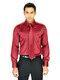
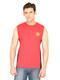
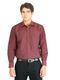

In [19]:
# Example usage
results = search_fashion("red shirt men", limit=3)
display_fashion_results(results)

## Additional Resources
- [VLM Run Documentation](https://docs.vlm.run)
- [API Reference](https://docs.vlm.run/)
- [More Examples](https://github.com/vlm-run/vlmrun-cookbook)
- [Lance Hybrid Search](https://lancedb.github.io/lancedb/hybrid_search/hybrid_search/)
- [Fashion Dataset](https://huggingface.co/datasets/ashraq/fashion-product-images-small)